In [55]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize, sent_tokenize
from bs4 import BeautifulSoup
import re
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

from collections import Counter
import pickle

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split

In [2]:
#importing the  data
imdb_data = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [3]:
imdb_data.shape

(50000, 2)

In [4]:
imdb_data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [5]:
imdb_data.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [6]:
imdb_data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [7]:
#Summary of the dataset
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [8]:
#sentiment count
imdb_data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

<Axes: xlabel='sentiment'>

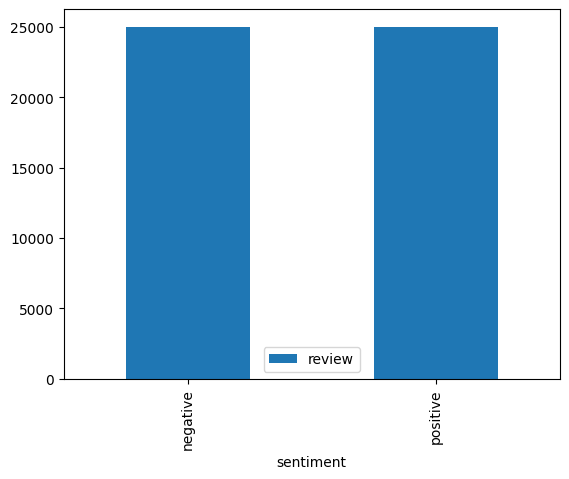

In [9]:
# The distribution of sentiments
imdb_data.groupby('sentiment').count().plot(kind = 'bar')

<Axes: >

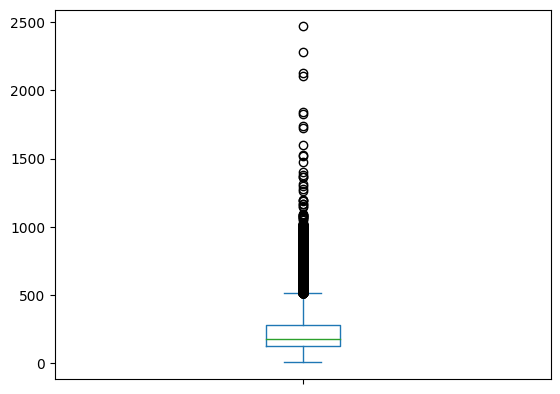

In [10]:
# Calculate review lengths
review_len = pd.Series([len(review.split()) for review in imdb_data['review']])

# The distribution of review text lengths
review_len.plot(kind = 'box')

In [11]:
labeling = {
    'positive':1, 
    'negative':0
}

imdb_data['sentiment_label'] = imdb_data['sentiment'].apply(lambda x : labeling[x])

# Output first ten rows
imdb_data.head(10)

,review,sentiment,sentiment_label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1
5,"Probably my all-time favorite movie, a story o...",positive,1
6,I sure would like to see a resurrection of a u...,positive,1
7,"This show was an amazing, fresh & innovative i...",negative,0
8,Encouraged by the positive comments about this...,negative,0
9,If you like original gut wrenching laughter yo...,positive,1


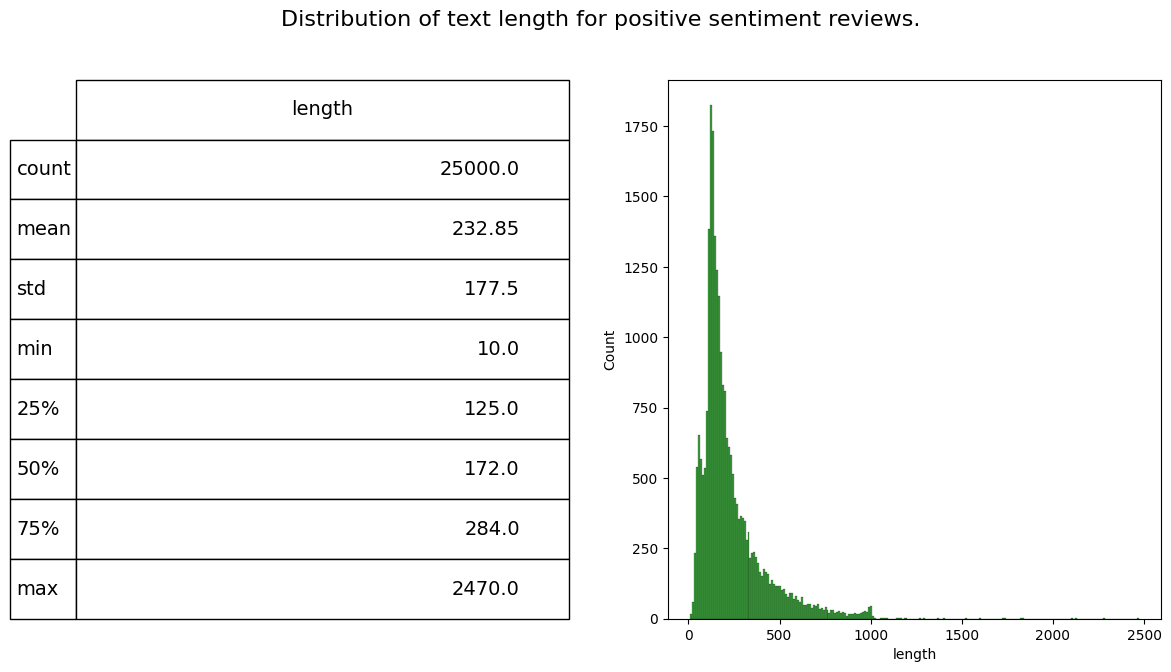

In [12]:
fig = plt.figure(figsize=(14,7))
imdb_data['length'] = imdb_data.review.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(imdb_data[imdb_data['sentiment_label']==1]['length'], ax=ax1,color='green')
describe = imdb_data.length[imdb_data.sentiment_label==1].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment reviews.', fontsize=16)

plt.show()

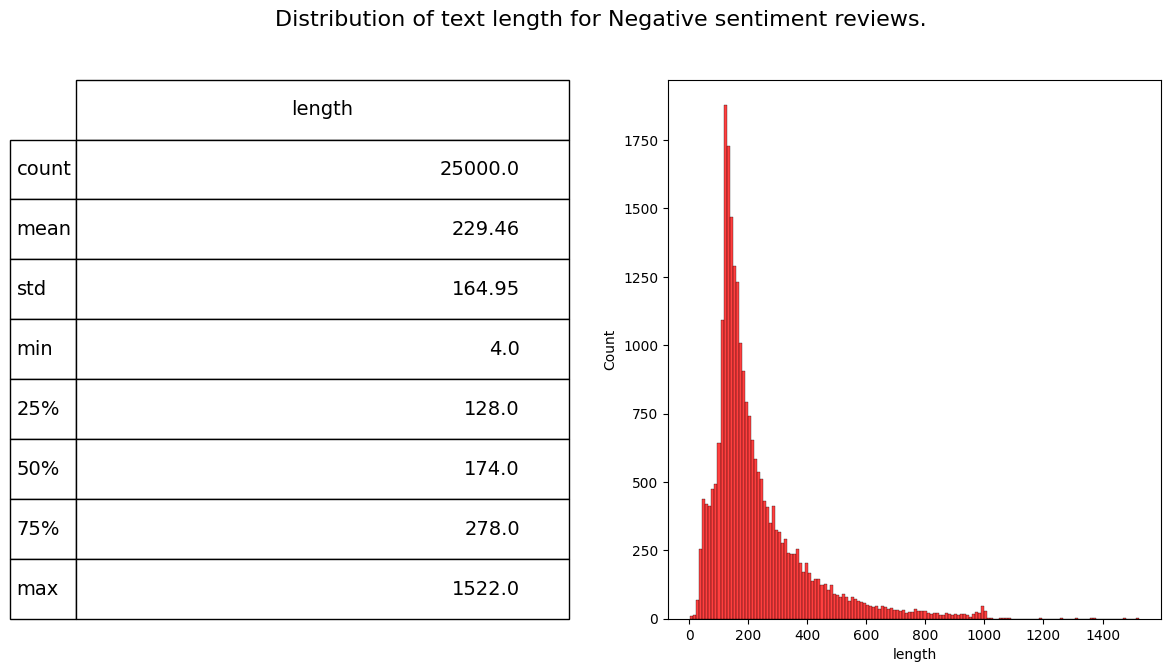

In [13]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(122)
sns.histplot(imdb_data[imdb_data['sentiment_label']==0]['length'], ax=ax1,color='red')
describe = imdb_data.length[imdb_data.sentiment_label==0].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment reviews.', fontsize=16)

plt.show()



In [15]:
#Tokenization of text
tokenizer = ToktokTokenizer()

In [27]:
#Setting English stopwords
stopword_list = nltk.corpus.stopwords.words('english')

In [16]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [17]:
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

In [18]:
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

In [19]:
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)

In [20]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text


In [21]:
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

In [22]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

In [23]:
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

In [26]:
#set stopwords to english
stop = set(stopwords.words('english'))
print(stop)

{'don', 'for', 'is', 'through', 'mustn', 'why', 'this', 'on', 'no', 'a', 'be', 'such', 'am', 'when', "needn't", 'own', 'they', "mustn't", 'those', 'will', 'once', "haven't", 'i', 'wasn', 'an', 'off', 'each', 'did', "wasn't", "that'll", 'only', 'or', 'that', "mightn't", 'then', "should've", 'again', 'until', 'out', 'up', 'after', "couldn't", 'wouldn', 'where', 'she', 'and', 'was', 'more', "you'd", 'themselves', 'm', 'we', 'from', 'are', 'yourself', 'if', 'aren', 'which', 'couldn', 'theirs', 'yours', 'you', "shan't", 'me', 'down', 'mightn', 'were', 'too', 'between', 'before', "won't", 'in', 'both', 'than', 'who', 'the', 't', 'him', 'nor', 'hasn', 'y', 'them', 'same', 'it', 'at', "don't", 'these', 'just', "she's", 'shouldn', 'ain', 'hers', 'their', 'needn', 'of', 'should', 'll', 'do', 'while', 'here', 'isn', 'has', 'hadn', "you've", 'his', 'most', 'my', 'its', 'had', 'during', 'there', "hasn't", 'doing', 'because', 'as', 'about', 'o', 'didn', 'by', 're', 'herself', 'shan', 'few', 'other',

In [28]:
#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
    
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

In [29]:
#normalized train reviews
norm_train_reviews=imdb_data.review[:40000]
norm_train_reviews[0]

'one review ha mention watch 1 Oz episod youll hook right thi exactli happen meth first thing struck Oz wa brutal unflinch scene violenc set right word GO trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call OZ nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda Em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast Oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp

In [30]:
#Normalized test reviews
norm_test_reviews = imdb_data.review[40000:]
norm_test_reviews[45005]

'read review watch thi piec cinemat garbag took least 2 page find somebodi els didnt think thi appallingli unfunni montag wasnt acm humour 70 inde ani era thi isnt least funni set sketch comedi ive ever seen itll till come along half skit alreadi done infinit better act monti python woodi allen wa say nice piec anim last 90 second highlight thi film would still get close sum mindless drivelridden thi wast 75 minut semin comedi onli world semin realli doe mean semen scatolog humour onli world scat actual fece precursor joke onli mean thi handbook comedi tit bum odd beaver niceif pubesc boy least one hand free havent found playboy exist give break becaus wa earli 70 way sketch comedi go back least ten year prior onli way could even forgiv thi film even made wa gunpoint retro hardli sketch clown subtli pervert children may cut edg circl could actual funni come realli quit sad kept go throughout entir 75 minut sheer belief may save genuin funni skit end gave film 1 becaus wa lower scoreand

In [31]:
#Count vectorizer for bag of words
cv = CountVectorizer(min_df = 0,
                     max_df = 1, 
                     binary = False,
                     ngram_range = (1 , 3))

#transformed train reviews
cv_train_reviews = cv.fit_transform(norm_train_reviews)

#transformed test reviews
cv_test_reviews = cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (40000, 6209089)
BOW_cv_test: (10000, 6209089)


In [33]:
#Tfidf vectorizer
tv = TfidfVectorizer(min_df = 0,
                     max_df = 1,
                     use_idf = True,
                     ngram_range = (1 , 3))

#transformed train reviews
tv_train_reviews = tv.fit_transform(norm_train_reviews)

#transformed test reviews
tv_test_reviews = tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6209089)
Tfidf_test: (10000, 6209089)


In [34]:
#labeling the sentient data
lb = LabelBinarizer()

#transformed sentiment data
sentiment_data = lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

(50000, 1)


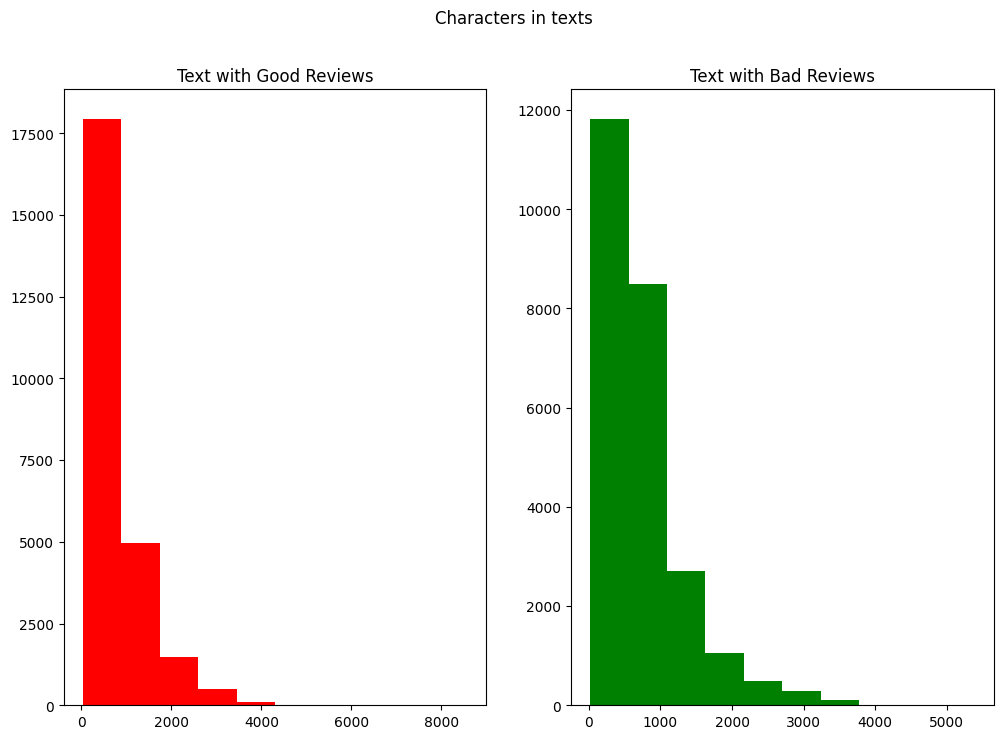

In [35]:
fig,(ax1 , ax2) = plt.subplots(1 , 2 , figsize = (12 , 8))
text_len = imdb_data[sentiment_data == 1]['review'].str.len()
ax1.hist(text_len,color = 'red')
ax1.set_title('Text with Good Reviews')
text_len = imdb_data[sentiment_data == 0]['review'].str.len()
ax2.hist(text_len,color = 'green')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Characters in texts')
plt.show()

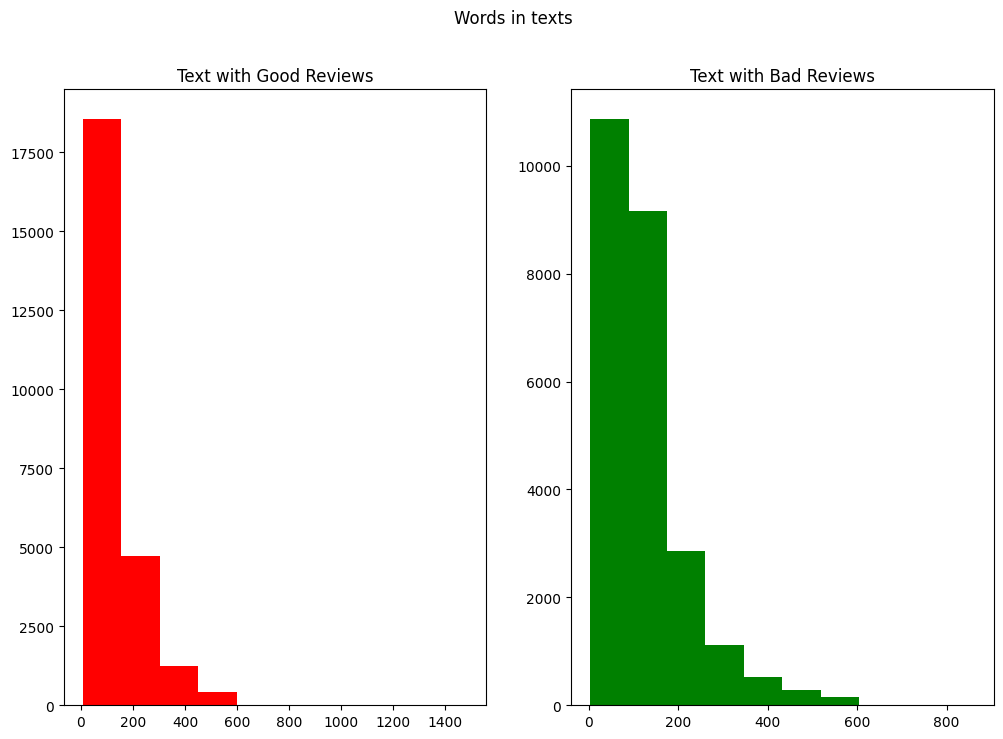

In [36]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=imdb_data[sentiment_data==1]['review'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Text with Good Reviews')
text_len=imdb_data[sentiment_data==0]['review'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Words in texts')
plt.show()

Text(0.5, 0.98, 'Average word length in each text')

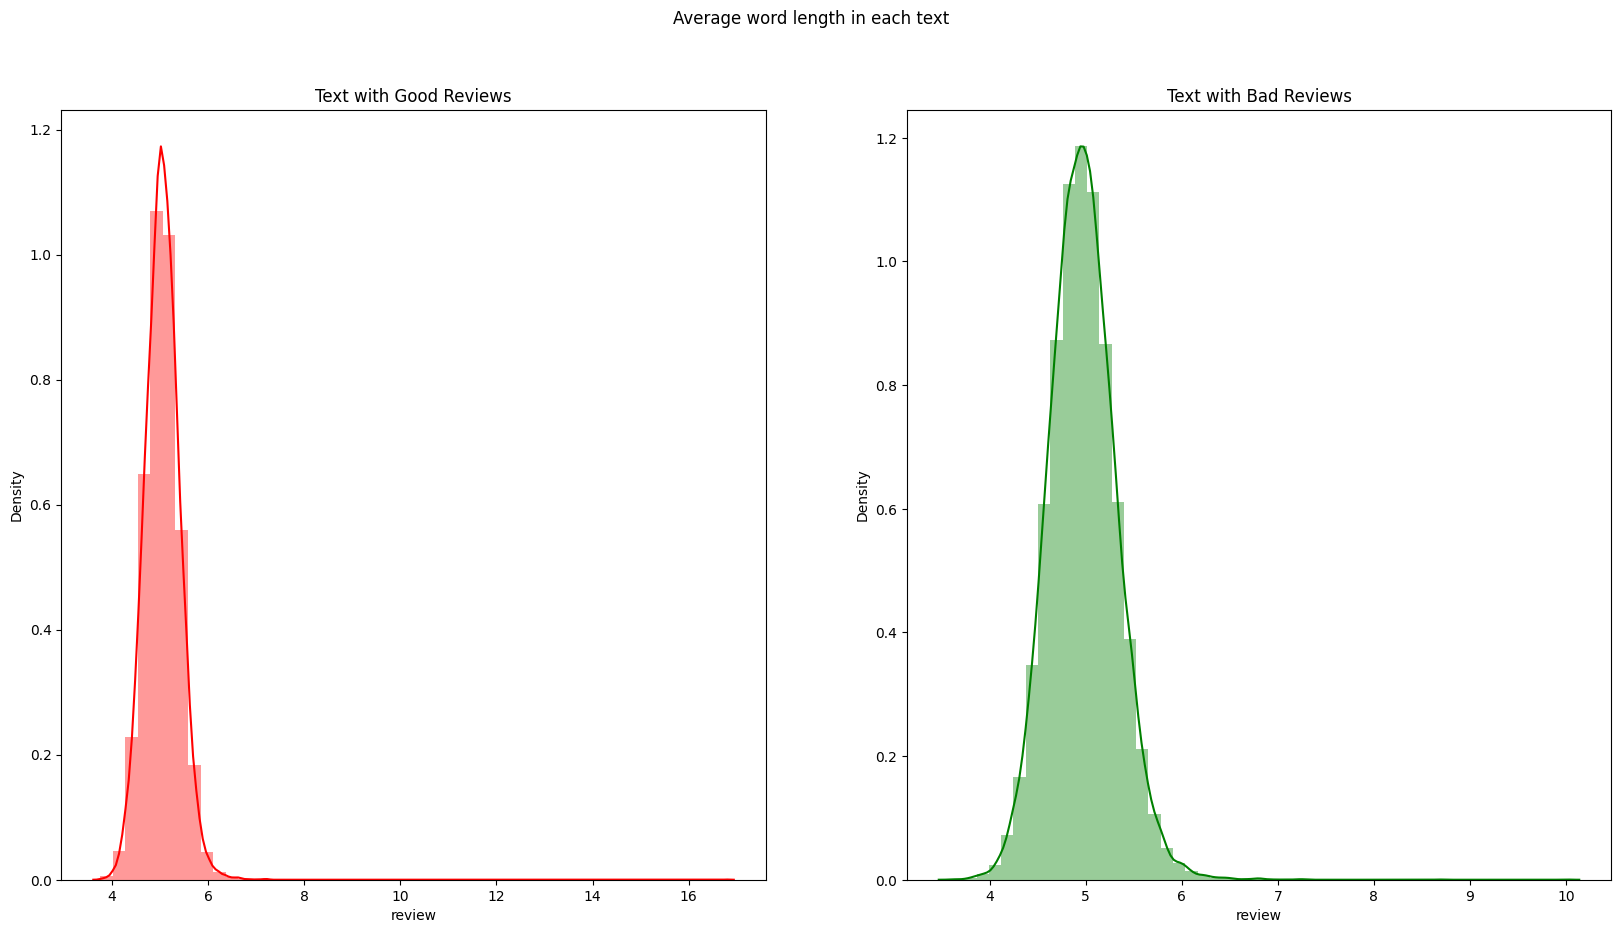

In [37]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=imdb_data[sentiment_data==1]['review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Text with Good Reviews')
word=imdb_data[sentiment_data==0]['review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Average word length in each text')

In [38]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
    
corpus = get_corpus(imdb_data.review)
corpus[:5]

['one', 'review', 'ha', 'mention', 'watch']

In [39]:
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'thi': 145461,
 'movi': 98936,
 'wa': 95191,
 'film': 92059,
 'hi': 57228,
 'one': 52649,
 'like': 43820,
 'ha': 33042,
 'time': 29798,
 'good': 28899}

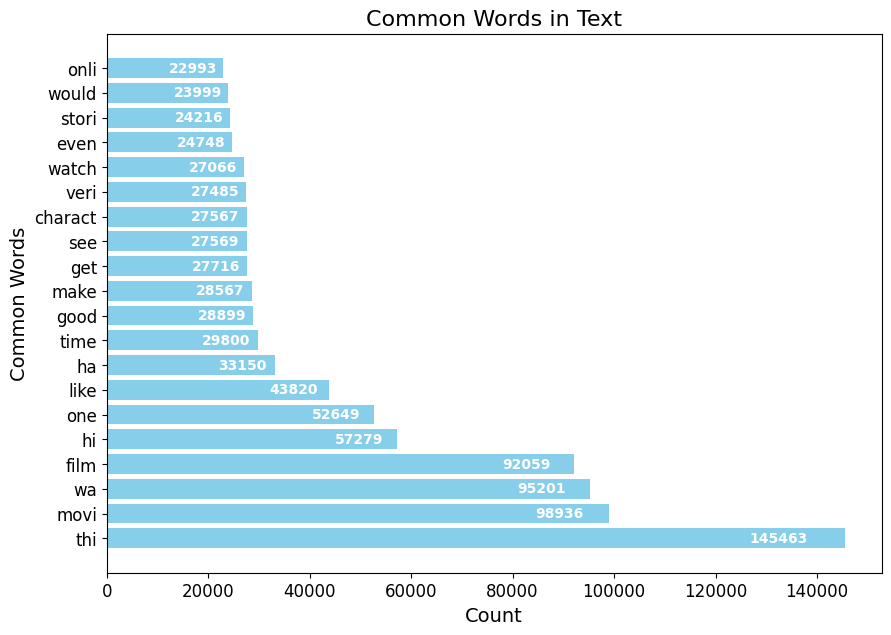

In [40]:
# Assuming imdb_data is a pandas DataFrame with a 'review' column containing text data.
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get most common unigrams
most_common_uni = get_top_text_ngrams(imdb_data['review'], 20, 1)
most_common_uni = dict(most_common_uni)

# Prepare data for plotting
temp = pd.DataFrame(columns=["Common_words", 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())

# Create a horizontal bar plot using Matplotlib
plt.figure(figsize=(10, 7))
bars = plt.barh(temp['Common_words'], temp['Count'], color='skyblue')

# Add labels inside the bars
for bar in bars:
    plt.text(bar.get_width() - bar.get_width() * 0.05, bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.0f}', va='center', ha='right', color='white', fontweight='bold')

# Customize labels and title
plt.xlabel('Count', fontsize=14)
plt.ylabel('Common Words', fontsize=14)
plt.title('Common Words in Text', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()


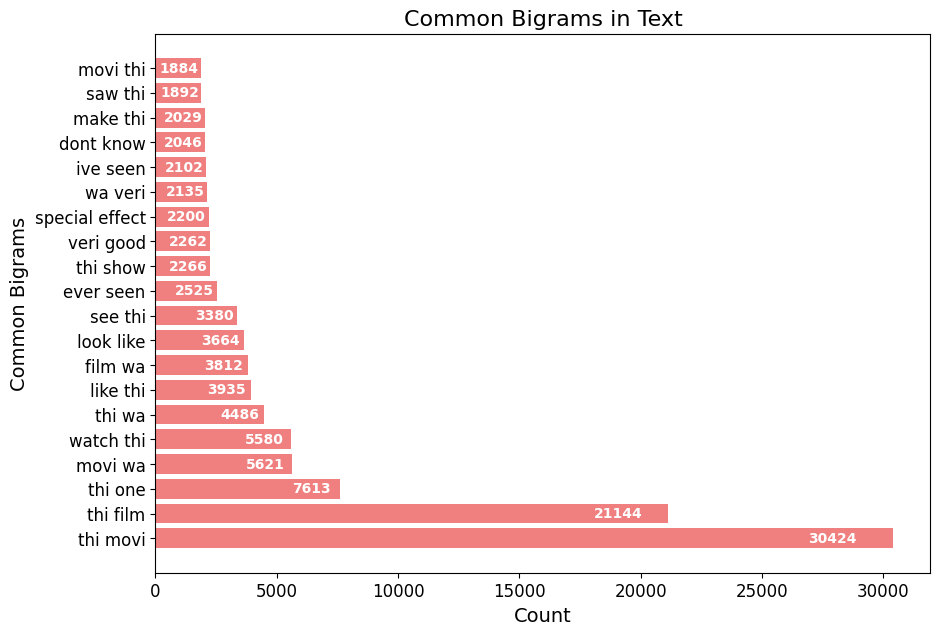

In [41]:
# Get most common bigrams
most_common_bi = get_top_text_ngrams(imdb_data['review'], 20, 2)
most_common_bi = dict(most_common_bi)

# Prepare data for plotting
temp = pd.DataFrame(columns=["Common_words", 'Count'])
temp["Common_words"] = list(most_common_bi.keys())
temp["Count"] = list(most_common_bi.values())

# Create a horizontal bar plot using Matplotlib
plt.figure(figsize=(10, 7))
bars = plt.barh(temp['Common_words'], temp['Count'], color='lightcoral')

# Add labels inside the bars
for bar in bars:
    plt.text(bar.get_width() - bar.get_width() * 0.05, bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.0f}', va='center', ha='right', color='white', fontweight='bold')

# Customize labels and title
plt.xlabel('Count', fontsize=14)
plt.ylabel('Common Bigrams', fontsize=14)
plt.title('Common Bigrams in Text', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()


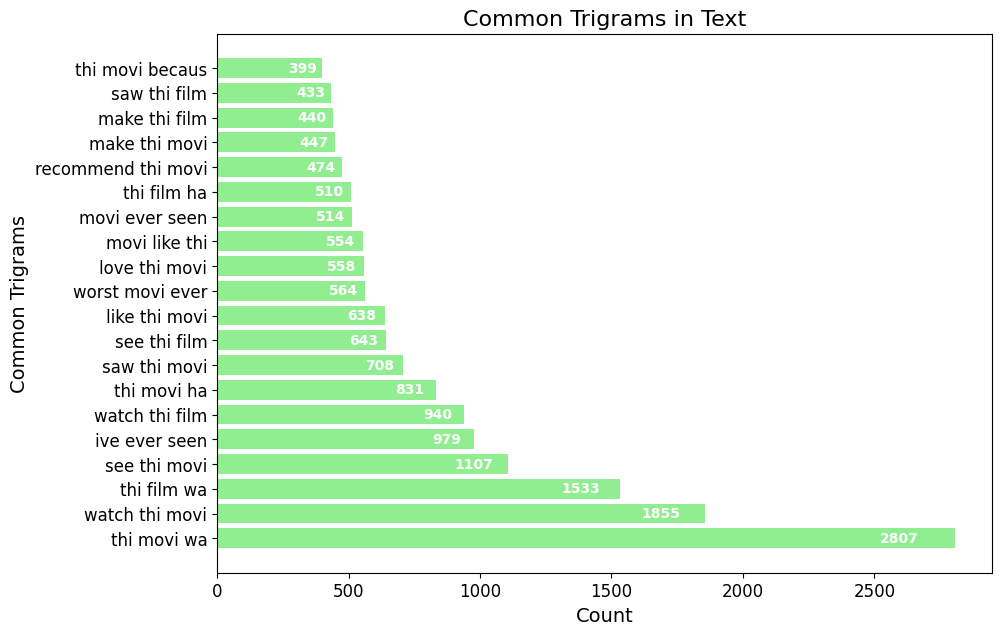

In [42]:
# Get most common trigrams
most_common_tri = get_top_text_ngrams(imdb_data['review'], 20, 3)
most_common_tri = dict(most_common_tri)

# Prepare data for plotting
temp = pd.DataFrame(columns=["Common_words", 'Count'])
temp["Common_words"] = list(most_common_tri.keys())
temp["Count"] = list(most_common_tri.values())

# Create a horizontal bar plot using Matplotlib
plt.figure(figsize=(10, 7))
bars = plt.barh(temp['Common_words'], temp['Count'], color='lightgreen')

# Add labels inside the bars
for bar in bars:
    plt.text(bar.get_width() - bar.get_width() * 0.05, bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.0f}', va='center', ha='right', color='white', fontweight='bold')

# Customize labels and title
plt.xlabel('Count', fontsize=14)
plt.ylabel('Common Trigrams', fontsize=14)
plt.title('Common Trigrams in Text', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()


In [43]:
#Spliting the sentiment data
train_sentiments = sentiment_data[:40000]
test_sentiments = sentiment_data[40000:]
print(train_sentiments)
print(test_sentiments)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [44]:
#training the model
lr = LogisticRegression(penalty = 'l2', max_iter = 500, C = 1, random_state = 42)

#Fitting the model for Bag of words
lr_bow = lr.fit(cv_train_reviews, train_sentiments)
print(lr_bow)

#Fitting the model for tfidf features
lr_tfidf = lr.fit(tv_train_reviews, train_sentiments)
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)
LogisticRegression(C=1, max_iter=500, random_state=42)


In [45]:
#Predicting the model for bag of words
lr_bow_predict = lr.predict(cv_test_reviews)
print(lr_bow_predict)

##Predicting the model for tfidf features
lr_tfidf_predict = lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


In [46]:
#Accuracy score for bag of words
lr_bow_score = accuracy_score(test_sentiments, lr_bow_predict)
print("lr_bow_score :", lr_bow_score)

#Accuracy score for tfidf features
lr_tfidf_score = accuracy_score(test_sentiments, lr_tfidf_predict)
print("lr_tfidf_score :", lr_tfidf_score)

lr_bow_score : 0.7512
lr_tfidf_score : 0.75


In [47]:
#Classification report for bag of words 
lr_bow_report = classification_report(test_sentiments, 
                                      lr_bow_predict,
                                      target_names = ['Positive', 'Negative'])

print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report = classification_report(test_sentiments,
                                        lr_tfidf_predict,
                                        target_names = ['Positive', 'Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.75      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.74      0.77      0.75      4993
    Negative       0.76      0.73      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [49]:
def plot_classification_report(report, title):
    # Parse the classification report into a dictionary
    report_dict = classification_report(test_sentiments, report, target_names=['Positive', 'Negative'], output_dict=True)
    
    # Convert the dictionary into a DataFrame
    df = pd.DataFrame(report_dict).T
    
    # Remove the "support" column for visualization purposes
    df = df.drop(columns=['support'])
    
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(df, annot=True, cmap="Blues", fmt=".2f")
    plt.title(title)
    plt.ylabel('Classes / Metrics')
    plt.xlabel('Metrics')
    plt.show()


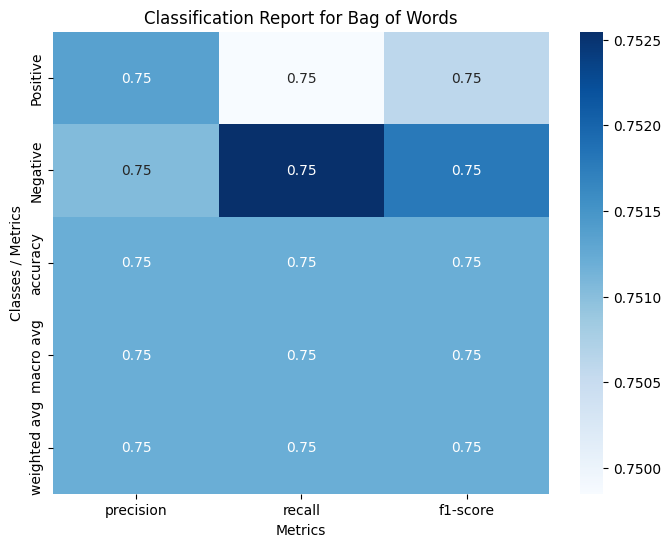

In [50]:
# Visualize classification reports
plot_classification_report(lr_bow_predict, "Classification Report for Bag of Words")

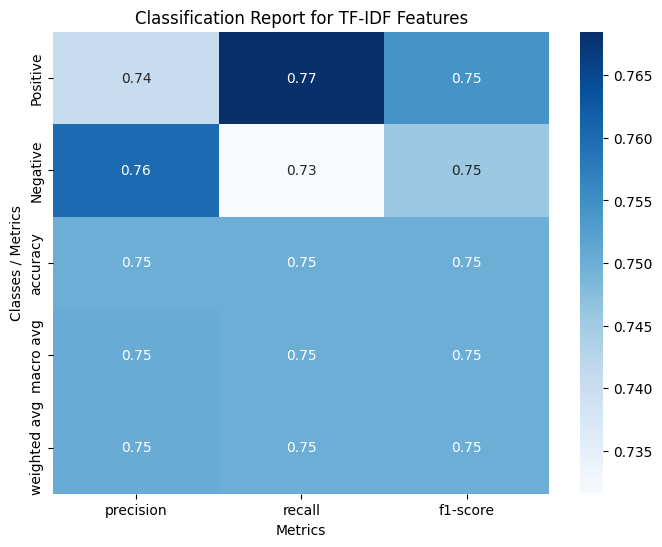

In [51]:
plot_classification_report(lr_tfidf_predict, "Classification Report for TF-IDF Features")

In [48]:
#confusion matrix for bag of words
cm_bow = confusion_matrix(test_sentiments, lr_bow_predict,labels = [1, 0])
print(cm_bow)

#confusion matrix for tfidf features
cm_tfidf = confusion_matrix(test_sentiments, lr_tfidf_predict, labels = [1, 0])
print(cm_tfidf)

[[3768 1239]
 [1249 3744]]
[[3663 1344]
 [1156 3837]]


In [52]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

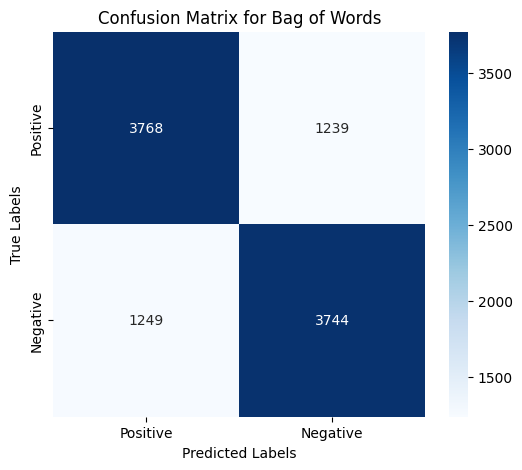

In [53]:
# Confusion Matrix for Bag of Words
cm_bow = confusion_matrix(test_sentiments, lr_bow_predict, labels=[1, 0])
plot_confusion_matrix(cm_bow, "Confusion Matrix for Bag of Words")

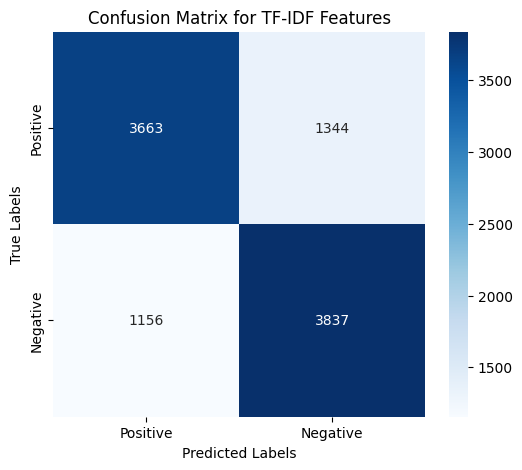

In [54]:
# Confusion Matrix for TF-IDF
cm_tfidf = confusion_matrix(test_sentiments, lr_tfidf_predict, labels=[1, 0])
plot_confusion_matrix(cm_tfidf, "Confusion Matrix for TF-IDF Features")

In [61]:
# Save the model
model_path = 'logistic_regression_model_tfidf.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(lr_tfidf, file)

In [59]:
# Save the model
model_path = 'TfidfVectorizer.pkl' 
with open(model_path, 'wb') as file:
    pickle.dump(tv, file)

In [63]:
# Load the vectorizer
vectorizer_path = '/kaggle/working/TfidfVectorizer.pkl' 
with open(vectorizer_path, 'rb') as file:
    vectorizer = pickle.load(file)

# Load the Logistic Regression model
model_path = '/kaggle/working/logistic_regression_model_tfidf.pkl' 
with open(model_path, 'rb') as file:
    loaded_model = pickle.load(file)


# Preprocess the text
text_vector = vectorizer.transform(["i hated the movie"])

# Predict sentiment
sentiment_scores = loaded_model.predict(text_vector)

print(sentiment_scores)

[0]


In [64]:
#training the linear svm
svm = SGDClassifier(loss = 'hinge',
                    max_iter = 500,
                    random_state = 42)

#fitting the svm for bag of words
svm_bow = svm.fit(cv_train_reviews, train_sentiments)
print(svm_bow)

#fitting the svm for tfidf features
svm_tfidf = svm.fit(tv_train_reviews,
                    train_sentiments)

print(svm_tfidf)

SGDClassifier(max_iter=500, random_state=42)
SGDClassifier(max_iter=500, random_state=42)


In [65]:
#Predicting the model for bag of words
svm_bow_predict = svm.predict(cv_test_reviews)
print(svm_bow_predict)

#Predicting the model for tfidf features
svm_tfidf_predict = svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[1 1 0 ... 1 1 1]
[1 1 1 ... 1 1 1]


In [66]:
#Accuracy score for bag of words
svm_bow_score = accuracy_score(test_sentiments, svm_bow_predict)
print("svm_bow_score :", svm_bow_score)

#Accuracy score for tfidf features
svm_tfidf_score = accuracy_score(test_sentiments, svm_tfidf_predict)
print("svm_tfidf_score :", svm_tfidf_score)

svm_bow_score : 0.5829
svm_tfidf_score : 0.5112


In [67]:
#Classification report for bag of words 
svm_bow_report = classification_report(test_sentiments,
                                       svm_bow_predict,
                                       target_names = ['Positive', 'Negative'])

print(svm_bow_report)

#Classification report for tfidf features
svm_tfidf_report = classification_report(test_sentiments,
                                         svm_tfidf_predict,
                                         target_names = ['Positive', 'Negative'])

print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.94      0.18      0.30      4993
    Negative       0.55      0.99      0.70      5007

    accuracy                           0.58     10000
   macro avg       0.74      0.58      0.50     10000
weighted avg       0.74      0.58      0.50     10000

              precision    recall  f1-score   support

    Positive       1.00      0.02      0.04      4993
    Negative       0.51      1.00      0.67      5007

    accuracy                           0.51     10000
   macro avg       0.75      0.51      0.36     10000
weighted avg       0.75      0.51      0.36     10000



In [69]:
#confusion matrix for bag of words
cm_bow = confusion_matrix(test_sentiments , svm_bow_predict, labels = [1 , 0])
print(cm_bow)

#confusion matrix for tfidf features
cm_tfidf = confusion_matrix(test_sentiments , svm_tfidf_predict , labels = [1 , 0])
print(cm_tfidf)

[[4948   59]
 [4112  881]]
[[5007    0]
 [4888  105]]


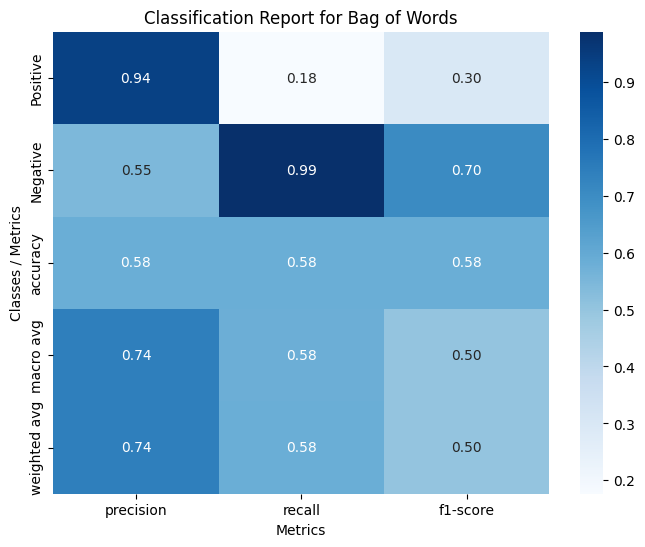

In [70]:
# Visualize classification reports
plot_classification_report(svm_bow_predict, "Classification Report for Bag of Words")

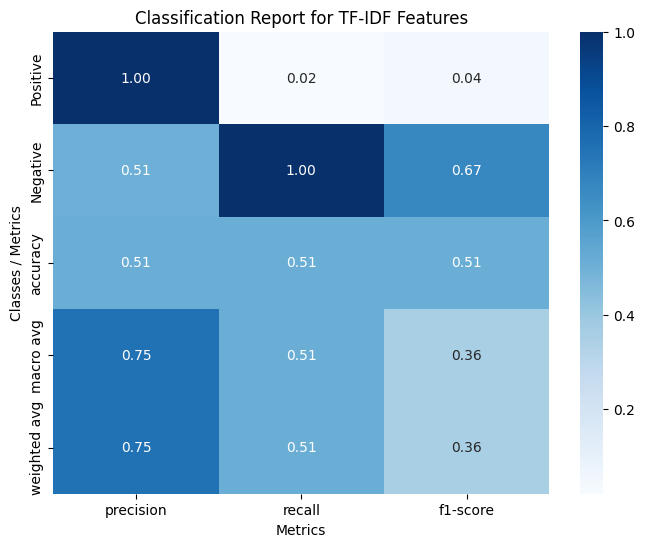

In [71]:
plot_classification_report(svm_tfidf_predict, "Classification Report for TF-IDF Features")

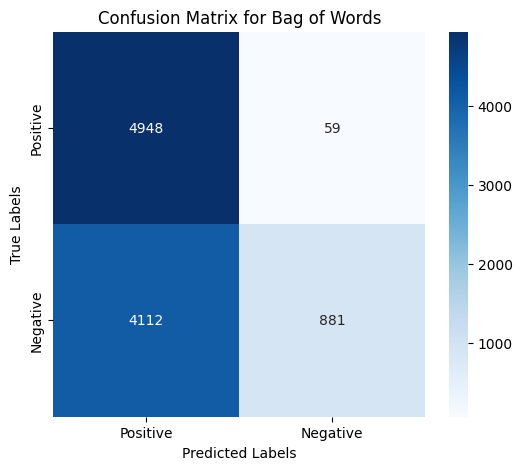

In [72]:
# Confusion Matrix for Bag of Words
cm_bow = confusion_matrix(test_sentiments, svm_bow_predict, labels=[1, 0])
plot_confusion_matrix(cm_bow, "Confusion Matrix for Bag of Words")


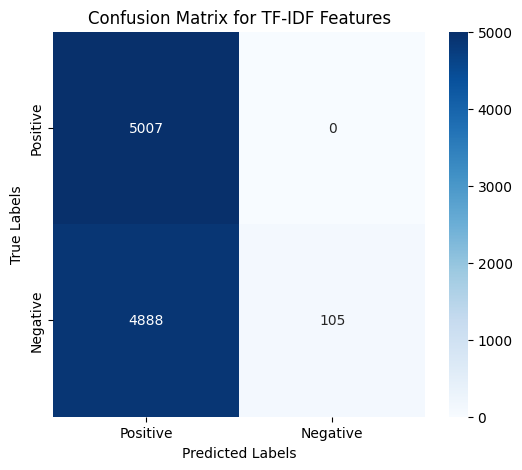

In [73]:
# Confusion Matrix for TF-IDF
cm_tfidf = confusion_matrix(test_sentiments, svm_tfidf_predict, labels=[1, 0])
plot_confusion_matrix(cm_tfidf, "Confusion Matrix for TF-IDF Features")

In [74]:
# Save the model
model_path = 'svm_model_tfidf.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(svm_tfidf, file)

In [75]:
# Load the vectorizer
vectorizer_path = '/kaggle/working/TfidfVectorizer.pkl' 
with open(vectorizer_path, 'rb') as file:
    vectorizer = pickle.load(file)

# Load the Logistic Regression model
model_path = '/kaggle/working/svm_model_tfidf.pkl' 
with open(model_path, 'rb') as file:
    loaded_model = pickle.load(file)


# Preprocess the text
text_vector = vectorizer.transform(["i hated the movie"])

# Predict sentiment
sentiment_scores = loaded_model.predict(text_vector)

print(sentiment_scores)

[1]


In [76]:
#training the model
mnb = MultinomialNB()

#fitting the svm for bag of words
mnb_bow = mnb.fit(cv_train_reviews, train_sentiments)
print(mnb_bow)

#fitting the svm for tfidf features
mnb_tfidf = mnb.fit(tv_train_reviews, train_sentiments)
print(mnb_tfidf)

MultinomialNB()
MultinomialNB()


In [77]:
#Predicting the model for bag of words
mnb_bow_predict = mnb.predict(cv_test_reviews)
print(mnb_bow_predict)

#Predicting the model for tfidf features
mnb_tfidf_predict = mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


In [78]:
#Accuracy score for bag of words
mnb_bow_score = accuracy_score(test_sentiments, mnb_bow_predict)
print("mnb_bow_score :", mnb_bow_score)

#Accuracy score for tfidf features
mnb_tfidf_score = accuracy_score(test_sentiments, mnb_tfidf_predict)
print("mnb_tfidf_score :", mnb_tfidf_score)

mnb_bow_score : 0.751
mnb_tfidf_score : 0.7509


In [79]:
#Classification report for bag of words 
mnb_bow_report = classification_report(test_sentiments,
                                       mnb_bow_predict,
                                       target_names = ['Positive' , 'Negative'])
print(mnb_bow_report)

#Classification report for tfidf features
mnb_tfidf_report = classification_report(test_sentiments,
                                         mnb_tfidf_predict,
                                         target_names = ['Positive' , 'Negative'])
print(mnb_tfidf_report)


              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.74      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [80]:
#confusion matrix for bag of words
cm_bow = confusion_matrix(test_sentiments,
                          mnb_bow_predict,
                          labels = [1 , 0])
print(cm_bow)

#confusion matrix for tfidf features
cm_tfidf = confusion_matrix(test_sentiments,
                            mnb_tfidf_predict,
                            labels = [1 , 0])
print(cm_tfidf)

[[3736 1271]
 [1219 3774]]
[[3729 1278]
 [1213 3780]]


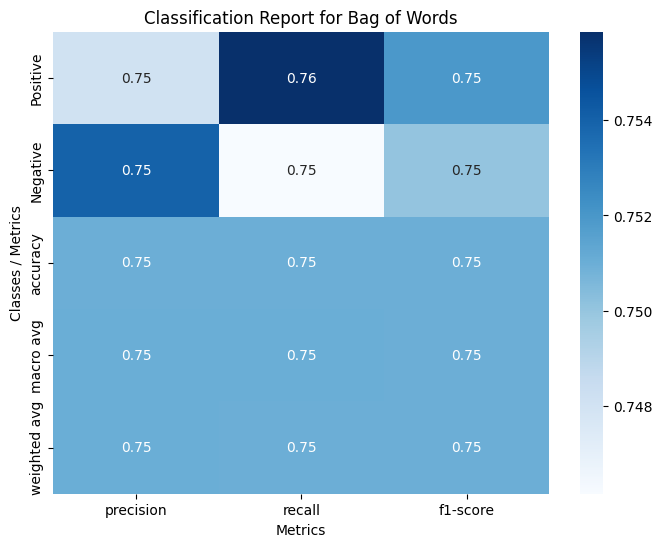

In [81]:
# Visualize classification reports
plot_classification_report(mnb_bow_predict, "Classification Report for Bag of Words")

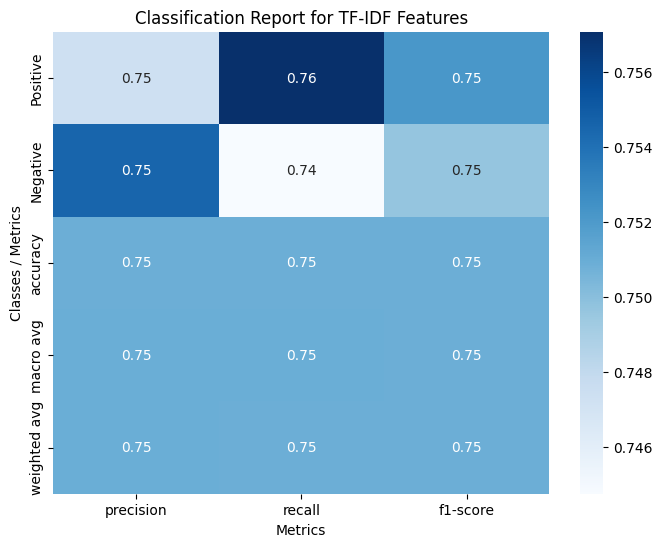

In [82]:
plot_classification_report(mnb_tfidf_predict, "Classification Report for TF-IDF Features")

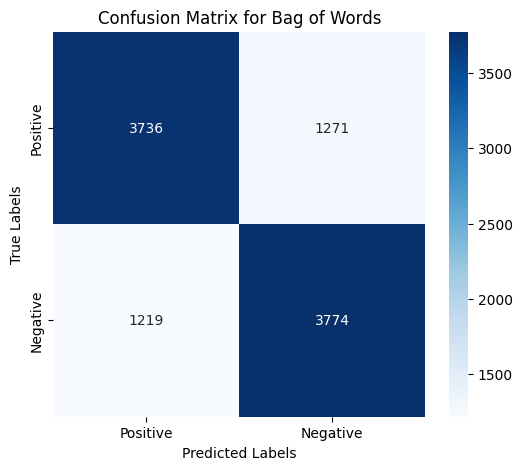

In [83]:
# Confusion Matrix for Bag of Words
cm_bow = confusion_matrix(test_sentiments, mnb_bow_predict, labels=[1, 0])
plot_confusion_matrix(cm_bow, "Confusion Matrix for Bag of Words")

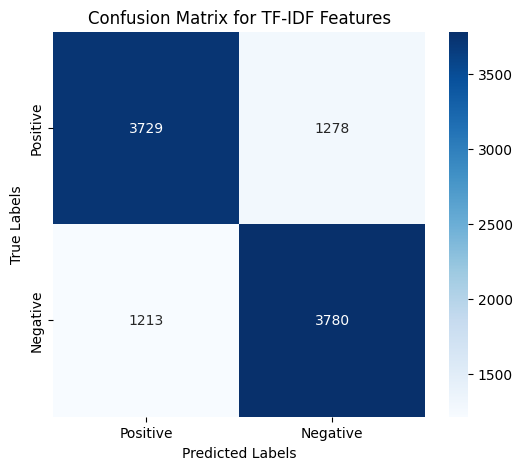

In [84]:
# Confusion Matrix for TF-IDF
cm_tfidf = confusion_matrix(test_sentiments, mnb_tfidf_predict, labels=[1, 0])
plot_confusion_matrix(cm_tfidf, "Confusion Matrix for TF-IDF Features")

In [85]:
# Save the model
model_path = 'MultinomialNB_model_tfidf.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(mnb_tfidf, file)
    
# Load the vectorizer
vectorizer_path = '/kaggle/working/TfidfVectorizer.pkl' 
with open(vectorizer_path, 'rb') as file:
    vectorizer = pickle.load(file)

# Load the Logistic Regression model
model_path = '/kaggle/working/MultinomialNB_model_tfidf.pkl' 
with open(model_path, 'rb') as file:
    loaded_model = pickle.load(file)


# Preprocess the text
text_vector = vectorizer.transform(["i hated the movie"])

# Predict sentiment
sentiment_scores = loaded_model.predict(text_vector)

print(sentiment_scores)

[0]


<function matplotlib.pyplot.show(close=None, block=None)>

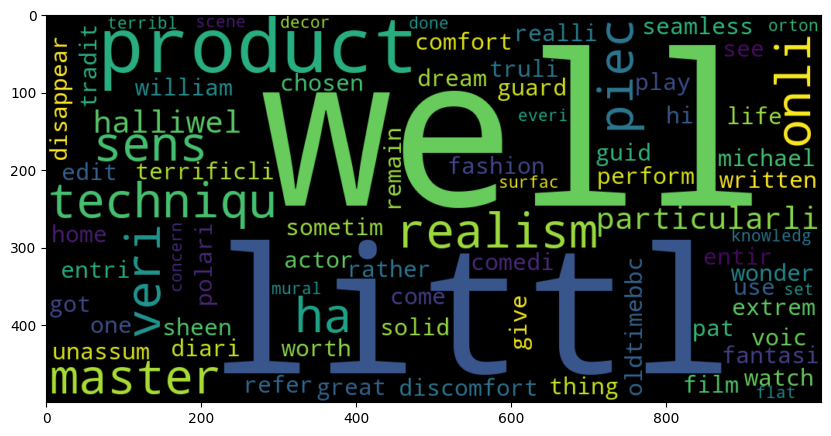

In [44]:
#word cloud for positive review words
plt.figure(figsize = (10, 10))
positive_text = norm_train_reviews[1]
WC = WordCloud(width = 1000,
               height = 500,
               max_words = 500,
               min_font_size = 5)

positive_words = WC.generate(positive_text)
plt.imshow(positive_words,
           interpolation = 'bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

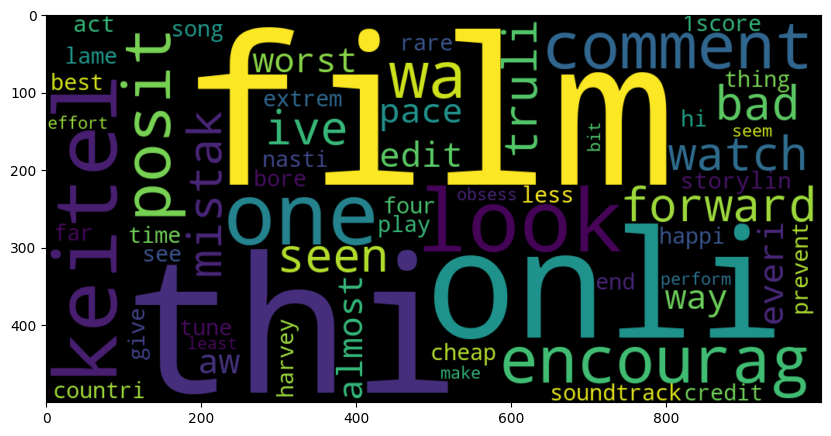

In [86]:
#Word cloud for negative review words
plt.figure(figsize = (10 , 10))
negative_text = norm_train_reviews[8]
WC = WordCloud(width = 1000,
               height = 500,
               max_words = 500,
               min_font_size = 5)

negative_words = WC.generate(negative_text)

plt.imshow(negative_words,
           interpolation = 'bilinear')

plt.show

In [4]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        """
        Initializes the dataset with texts, labels, a tokenizer, and a maximum sequence length.
        
        Args:
            texts (list): List of text data (e.g., movie reviews).
            labels (list): List of corresponding labels (e.g., 0 for negative, 1 for positive).
            tokenizer: Tokenizer to convert text into token ids that BERT can process.
            max_length (int): Maximum sequence length for tokenized input.
        """
        self.texts = texts  # List of texts to be classified
        self.labels = labels  # Corresponding labels for each text
        self.tokenizer = tokenizer  # Tokenizer instance (e.g., BERT tokenizer)
        self.max_length = max_length  # Maximum length of tokenized sequences

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        
        Returns:
            int: The number of samples in the dataset.
        """
        return len(self.texts)  # Length of the dataset (number of texts)

    def __getitem__(self, idx):
        """
        Retrieves the tokenized representation of a text sample and its label by index.
        
        Args:
            idx (int): Index of the sample to retrieve.
        
        Returns:
            dict: A dictionary containing input_ids, attention_mask, and label tensors.
        """
        text = self.texts[idx]  # Get the text at the specified index
        label = self.labels[idx]  # Get the label at the specified index

        # Tokenize the text, convert it to tensors, and ensure it fits the max_length
        encoding = self.tokenizer(
            text,
            return_tensors='pt',  # Return as PyTorch tensors
            max_length=self.max_length,  # Truncate or pad sequences to max_length
            padding='max_length',  # Pad sequences shorter than max_length
            truncation=True  # Truncate sequences longer than max_length
        )

        # Return the tokenized input ids, attention mask, and label as a flattened tensor
        return {
            'input_ids': encoding['input_ids'].flatten(),  # Flatten the input ids tensor
            'attention_mask': encoding['attention_mask'].flatten(),  # Flatten the attention mask tensor
            'label': torch.tensor(label)  # Convert label to a tensor
        }


In [5]:
data_file = "/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv"
df = pd.read_csv(data_file).head(10000)



texts = df['review'].tolist()
labels = [1 if sentiment == "positive" else 0 for sentiment in df['sentiment'].tolist()] # Encoding the target column.


train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)


In [6]:
# Name of the pre-trained BERT model to be used.
# 'bert-base-uncased' is a lowercased version of BERT with 12 layers and 110 million parameters.
bert_model_name = 'bert-base-uncased'

# The tokenizer converts raw text into tokens that can be processed by the BERT model.
tokenizer = BertTokenizer.from_pretrained(bert_model_name)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
# Number of classes for the classification task.
# In this case, 2 classes correspond to binary classification (e.g., positive or negative sentiment).
num_classes = 2

# Maximum length of the tokenized input sequences.
# Sequences longer than this will be truncated, and shorter sequences will be padded.
max_length = 256

# Number of samples per batch during training.
# A batch size of 32 is commonly used for BERT models, balancing between memory usage and training speed.
batch_size = 64

# Number of epochs to train the model.
# 4 epochs is often sufficient for fine-tuning BERT, but this can be adjusted based on performance.
num_epochs = 1

# Learning rate for the optimizer.
# 2e-5 is a commonly used learning rate for fine-tuning BERT, as it tends to provide good convergence.
learning_rate = 2e-5

# Determine the device to run the model on.
# If a GPU is available, it will use 'cuda'; otherwise, it will default to the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Create a dataset for the training data.
# This dataset will handle tokenizing the texts and preparing the labels.
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)

# Create a dataset for the validation data.
# This will be used to evaluate the model's performance during training.
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)

# Create a DataLoader for the training dataset.
# The DataLoader will handle batching, shuffling, and other data management tasks during training.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create a DataLoader for the validation dataset.
# This DataLoader will not shuffle the data, as the order of evaluation doesn't affect validation.
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


In [9]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        """
        Initializes the BERT-based classifier model.
        
        Args:
            bert_model_name (str): The name of the pre-trained BERT model to load (e.g., 'bert-base-uncased').
            num_classes (int): The number of output classes (e.g., 2 for binary classification).
        """
        super(BERTClassifier, self).__init__()
        
        # Load the pre-trained BERT model from Hugging Face's transformers library
        self.bert = BertModel.from_pretrained(bert_model_name)
        
        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.1)  # Dropout with a probability of 0.1
        
        # Fully connected layer that maps the BERT output to the desired number of classes
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
        # self.bert.config.hidden_size: The hidden size of the BERT model (e.g., 768 for BERT-base)
        # num_classes: The number of classes for classification (e.g., 2 for binary classification)

    def forward(self, input_ids, attention_mask):
        """
        Forward pass for the BERTClassifier.
        
        Args:
            input_ids (torch.Tensor): Tensor of token ids of shape (batch_size, sequence_length).
            attention_mask (torch.Tensor): Tensor indicating the presence of actual tokens vs padding.
        
        Returns:
            torch.Tensor: Logits output by the model of shape (batch_size, num_classes).
        """
        # Pass the input_ids and attention_mask through BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Get the pooled output from BERT (corresponding to the [CLS] token)
        pooled_output = outputs.pooler_output
        
        # Apply dropout to the pooled output to prevent overfitting
        x = self.dropout(pooled_output)
        
        # Pass the output through the fully connected layer to get logits
        logits = self.fc(x)
        
        return logits  # Return the logits, which are the raw predictions for each class

In [10]:
device

device(type='cuda')

In [11]:
import torch

torch.cuda.empty_cache()  # Free cached memory
torch.cuda.synchronize()  # Ensure all GPU operations are completed


In [12]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [13]:
model = BERTClassifier(bert_model_name, num_classes).to(device) # The model is moved to the appropriate device (GPU or CPU) for training and evaluation.

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [14]:
# Initialize the AdamW optimizer, specifically designed for working with transformer models like BERT.
# The optimizer will adjust the model's parameters during training to minimize the loss.
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Calculate the total number of training steps.
# This is the number of batches in the training set times the number of epochs.
total_steps = len(train_dataloader) * num_epochs

# Create a learning rate scheduler with a linear warmup and decay.
# The learning rate will start at 0, increase linearly to the initial learning rate, then decrease linearly to 0.
# num_warmup_steps = 0 means there is no warmup, and num_training_steps defines how long the training will take.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
def train(model, data_loader, optimizer, scheduler, device):
    """
    Trains the BERT model for one epoch.

    Args:
        model (nn.Module): The BERTClassifier model to be trained.
        data_loader (DataLoader): DataLoader containing the training data.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        scheduler (torch.optim.lr_scheduler): Learning rate scheduler for adjusting the learning rate.
        device (torch.device): Device on which the model and data will be loaded (e.g., 'cuda' or 'cpu').
    """
    
    # Set the model to training mode
    model.train()
    
    # Iterate over batches of data from the data loader
    for batch in data_loader:
        # Zero the gradients from the previous step to prevent accumulation
        optimizer.zero_grad()
        
        # Move the input data and labels to the specified device (GPU or CPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Perform a forward pass through the model to get the output logits
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Calculate the cross-entropy loss between the model outputs and the true labels
        loss = nn.CrossEntropyLoss()(outputs, labels)
        
        # Perform backpropagation to compute gradients for the model parameters
        loss.backward()
        
        # Update the model parameters using the computed gradients
        optimizer.step()
        
        # Update the learning rate according to the learning rate scheduler
        scheduler.step()


In [16]:
def evaluate(model, data_loader, device):
    """
    Evaluates the BERT model on the given dataset.

    Args:
        model (nn.Module): The BERTClassifier model to be evaluated.
        data_loader (DataLoader): DataLoader containing the validation or test data.
        device (torch.device): Device on which the model and data will be loaded (e.g., 'cuda' or 'cpu').

    Returns:
        float: The accuracy of the model on the given dataset.
        dict: A detailed classification report including precision, recall, f1-score for each class.
    """
    
    # Set the model to evaluation mode
    model.eval()
    
    # Lists to store predictions and actual labels
    predictions = []
    actual_labels = []
    
    # Disable gradient computation, as we are only evaluating the model
    with torch.no_grad():
        # Iterate over batches of data from the data loader
        for batch in data_loader:
            # Move the input data and labels to the specified device (GPU or CPU)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Perform a forward pass through the model to get the output logits
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # Get the index of the highest logit (predicted class)
            _, preds = torch.max(outputs, dim=1)
            
            # Append the predictions and actual labels to their respective lists
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    
    # Calculate accuracy and generate a classification report
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

In [17]:
for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}", end='\t')
        train(model, train_dataloader, optimizer, scheduler, device)
        accuracy, report = evaluate(model, val_dataloader, device)
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(report)

Epoch 1/1	Validation Accuracy: 0.9070
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       996
           1       0.90      0.92      0.91      1004

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



In [18]:
torch.save(model.state_dict(), "bert_classifier.pth")

In [19]:
import torch

def predict_sentiment(text, model, tokenizer, device, max_length=128):
    """
    Predicts the sentiment of a given text using the trained BERT model.

    Args:
        text (str): The text to classify.
        model (nn.Module): The trained BERTClassifier model.
        tokenizer (BertTokenizer): The tokenizer used to convert text into tokens.
        device (torch.device): Device on which the model and data will be loaded (e.g., 'cuda' or 'cpu').
        max_length (int): Maximum length of the tokenized input sequences (default is 128).

    Returns:
        str: The predicted sentiment, either "positive" or "negative".
    """
    
    # Set the model to evaluation mode
    model.eval()
    
    # Tokenize the input text and convert it to the format required by BERT
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    
    # Extract input_ids and attention_mask from the encoding and move them to the specified device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Disable gradient computation for inference
    with torch.no_grad():
        # Perform a forward pass through the model to get the output logits
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Get the index of the highest logit (predicted class)
        _, preds = torch.max(outputs, dim=1)
    
    # Convert the predicted class index to the corresponding sentiment label
    return "positive" if preds.item() == 1 else "negative"

In [20]:
# Test sentiment prediction
test_text = "The movie was great and I really enjoyed the performances of the actors."
sentiment = predict_sentiment(test_text, model, tokenizer, device)
print("The movie was great and I really enjoyed the performances of the actors.")
print(f"Predicted sentiment: {sentiment}")

The movie was great and I really enjoyed the performances of the actors.
Predicted sentiment: positive


In [21]:
# Test sentiment prediction
test_text = "The movie was so bad and I would not recommend it to anyone."
sentiment = predict_sentiment(test_text, model, tokenizer, device)
print("The movie was so bad and I would not recommend it to anyone.")
print(f"Predicted sentiment: {sentiment}")

The movie was so bad and I would not recommend it to anyone.
Predicted sentiment: negative


In [22]:
# Test sentiment prediction
test_text = "Worst movie of the year."
sentiment = predict_sentiment(test_text, model, tokenizer, device)
print("Worst movie of the year.")
print(f"Predicted sentiment: {sentiment}")


Worst movie of the year.
Predicted sentiment: negative


In [28]:
# Test sentiment prediction
test_text = "The movie was not good not bad."
sentiment = predict_sentiment(test_text, model, tokenizer, device)
print("The movie was not good not bad.")
print(f"Predicted sentiment: {sentiment}")


The movie was not good not bad.
Predicted sentiment: negative


In [52]:
import pandas as pd

df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

df.dropna(inplace=True)

import nltk
nltk.download('vader_lexicon')




from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia=SentimentIntensityAnalyzer()
sia.polarity_scores(df.iloc[0]['review'])

#add a column
df['score']=df['review'].apply(lambda review:sia.polarity_scores(review))


df['compound']=df['score'].apply(lambda d:d['compound'])


df['compound_score']=df['compound'].apply(lambda score:'positive' if score>=0 else 'negative' )



from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
accuracy_score(df['sentiment'],df['compound_score'])



print(classification_report(df['sentiment'],df['compound_score']))


print(confusion_matrix(df['sentiment'],df['compound_score']))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
              precision    recall  f1-score   support

    negative       0.79      0.53      0.64     25000
    positive       0.65      0.86      0.74     25000

    accuracy                           0.69     50000
   macro avg       0.72      0.69      0.69     50000
weighted avg       0.72      0.69      0.69     50000

[[13307 11693]
 [ 3594 21406]]


In [53]:
# Define a new text
new_text = "This movie was absolutely fantastic! The acting and storyline were amazing."

# Get the sentiment scores
sentiment_scores = sia.polarity_scores(new_text)

# Print the scores
print(f"Sentiment Scores: {sentiment_scores}")

# Classify as positive or negative based on the compound score
if sentiment_scores['compound'] >= 0:
    sentiment = 'positive'
else:
    sentiment = 'negative'

print(f"Overall Sentiment: {sentiment}")


Sentiment Scores: {'neg': 0.0, 'neu': 0.53, 'pos': 0.47, 'compound': 0.8395}
Overall Sentiment: positive


In [54]:
import pickle

# Save the object to a file
with open('sia_model.pkl', 'wb') as file:
    pickle.dump(sia, file)

print("VADER SentimentIntensityAnalyzer saved to 'sia_model.pkl'.")

VADER SentimentIntensityAnalyzer saved to 'sia_model.pkl'.


In [55]:
# Load the object from the file
with open('/kaggle/working/sia_model.pkl', 'rb') as file:
    loaded_sia = pickle.load(file)

# Verify by analyzing a text
text = "This is an amazing experience!"
print(loaded_sia.polarity_scores(text))

{'neg': 0.0, 'neu': 0.494, 'pos': 0.506, 'compound': 0.6239}


In [56]:
import nltk
print("NLTK version:", nltk.__version__)


NLTK version: 3.2.4


In [9]:
!pip install textblob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.


In [10]:
from textblob import TextBlob
import nltk
nltk.download('punkt')  # Required for tokenization


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
import pandas as pd

# Assuming df is already loaded
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

# Remove missing values
df.dropna(inplace=True)

# Add a column for polarity scores
df['polarity'] = df['review'].apply(lambda review: TextBlob(review).sentiment.polarity)

# Add a column for subjectivity scores
df['subjectivity'] = df['review'].apply(lambda review: TextBlob(review).sentiment.subjectivity)

# Classify sentiment based on polarity
df['sentiment_pred'] = df['polarity'].apply(lambda score: 'positive' if score > 0 else ('negative' if score < 0 else 'neutral'))

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming the original sentiment is in `sentiment` column
print(accuracy_score(df['sentiment'], df['sentiment_pred']))
print(classification_report(df['sentiment'], df['sentiment_pred']))
print(confusion_matrix(df['sentiment'], df['sentiment_pred']))


0.6881


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.89      0.43      0.58     25000
     neutral       0.00      0.00      0.00         0
    positive       0.62      0.95      0.75     25000

    accuracy                           0.69     50000
   macro avg       0.51      0.46      0.44     50000
weighted avg       0.76      0.69      0.67     50000

[[10725    22 14253]
 [    0     0     0]
 [ 1311     9 23680]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
import pickle
from textblob import TextBlob

class TextBlobPipeline:
    def analyze_text(self, text):
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity
        sentiment = 'positive' if polarity > 0 else ('negative' if polarity < 0 else 'neutral')
        return polarity, sentiment

    def process_dataframe(self, df):
        df['polarity'] = df['review'].apply(lambda review: TextBlob(review).sentiment.polarity)
        df['sentiment_pred'] = df['polarity'].apply(
            lambda score: 'positive' if score > 0 else ('negative' if score < 0 else 'neutral')
        )
        return df



pipeline = TextBlobPipeline()
with open('textblob_pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

print("Pipeline saved to 'textblob_pipeline.pkl'.")


Pipeline saved to 'textblob_pipeline.pkl'.


In [15]:
# Load the pipeline
with open('/kaggle/working/textblob_pipeline.pkl', 'rb') as file:
    loaded_pipeline = pickle.load(file)

# Analyze a single text
text = "This is absolutely wonderful!"
polarity, sentiment = loaded_pipeline.analyze_text(text)
print(f"Polarity: {polarity}, Sentiment: {sentiment}")

# Analyze a DataFrame
new_data = pd.DataFrame({'review': ["Terrible movie!", "I enjoyed it thoroughly."]})
processed_data = loaded_pipeline.process_dataframe(new_data)
print(processed_data)


Polarity: 1.0, Sentiment: positive
                     review  polarity sentiment_pred
0           Terrible movie!      -1.0       negative
1  I enjoyed it thoroughly.       0.5       positive
